#Machine Perception-Project 1
Vaibhav Mahapatra, Ojas Taskar

Johns Hopkins University

In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import time
import matplotlib.pyplot as plt
import torchvision.models as models

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:11<00:00, 14680182.30it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Data Visualization

In [ ]:
batch_size = 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

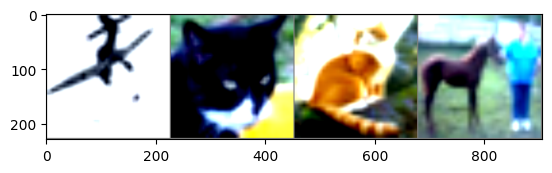

plane cat   cat   horse


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
# Helper function to see the number of trainable parameters in a model
total_params = lambda model: sum(p.numel() for p in model.parameters() if p.requires_grad)

## Defining Helper Functions

In [ ]:
def train_model(model: torch.nn.Module, train_dl: torch.utils.data.DataLoader, val_dl: torch.utils.data.DataLoader, n_epochs: int, lr):
    '''
    Trains a Pytorch Neural Network, given optimizer and no. of epochs to yield the training and validation losses throughout training

    Input
    model - Pytorch model which is inherited from torch.nn.Model
    train_dl - Train dataloader
    val_dl - Validation dataloader
    optimizer - Pytorch optimizer which is already initialized with model params and hyperparams
    n_epochs - No. of epochs to train the model
    lr - learning rate

    Output
    train_history - list of mean training loss per epoch
    val_history - list of mean validation loss per epoch
    '''
    # Moving Model to GPU if it isn't already on the GPU
    if next(model.parameters()).is_cuda == False:
        model.to(device)

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-3)
    criterion = nn.CrossEntropyLoss()
    train_history, val_history = [], []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        epoch_start = time.time()
        # Validation Data
        model.eval()
        epoch_loss = 0
        with torch.no_grad():
            for inputs, labels in val_dl:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_loss += loss.item()

        val_history.append(epoch_loss/len(val_dl))

        # Train Data
        model.train()
        epoch_loss = 0
        for inputs, labels in train_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Batch Loss
            epoch_loss += loss.item()

        train_history.append(epoch_loss/len(train_dl))
        # if int((epoch+1)/n_epochs*100) % 10 == 0:
        print(f'Epoch {epoch + 1} / {n_epochs}   Train_loss: {train_history[-1]:.3f}   Val_loss: {val_history[-1]:.3f}   Time: {(time.time()-epoch_start)/60:.3f} mins')

    print('Finished Training\n')
    return train_history, val_history

In [ ]:
def evaluate_model(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    '''
    Computes model accuracy, f1 and confusion matrix

    Input
    model - Pytorch model
    dataloader - dataset loaded in a dataloader

    Output
    acc - accuracy of the model
    f1 - f1_score
    confusion_mat - confusion matrix of the predictions
    '''
    model.eval()
    with torch.no_grad():
        total, correct = 0, 0
        f1_list = []
        confusion_mat = np.zeros((10, 10))
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            f1_list.append(f1_score(labels.cpu(), predicted.cpu(), average="macro"))

            # Updating confusion matrix
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_mat[t.item(), p.item()] += 1

    acc = correct / total
    f1 = np.mean(np.array(f1_list))

    return acc, f1, confusion_mat

In [ ]:
def plot_losses(train_hist, val_hist, caption):
    '''
    Plots the trianing and validation curves
    '''
    fig, ax = plt.subplots(1,1)
    ax.plot(np.log(np.array(train_hist)), label="Training Loss")
    ax.plot(np.log(np.array(val_hist)), label="Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Log Loss")
    ax.set_title(caption)
    ax.legend()
    ax.grid()
    fig.savefig(caption)

## Convolutional Neural Networks (CNNs)

### Building our own CNNs

In [ ]:
#Training and testing data
#CIFAR-10
batch_size = 32

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_size = int(0.8*len(trainset))
val_size = len(trainset) - train_size
trainset,valset = random_split(trainset,[train_size,val_size])


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset,batch_size = batch_size,shuffle=True,num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False,num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 50.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
#First architecture. LeNet5. We use mainly 2d convolutions, batch normalization and fully connected layers.
class Net1(nn.Module):
  def __init__(self):
    super(Net1, self).__init__()

    self.conv1 = nn.Conv2d(3,6,5)
    self.bn1 = nn.BatchNorm2d(6)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16*5*5,120)
    self.bn2 = nn.BatchNorm1d(120)
    self.fc2 =  nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))

    x = self.pool(F.relu(self.conv2(x)))

    x =  torch.flatten(x,1) #All dimensions except batch
    x = F.relu(self.bn2(self.fc1(x)))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
#Second architecture. Denser feature maps, used more layers as well as dropout. Sigmoid activation is used at one instance. Batch Norm is used after convolution layer.
class Net2(nn.Module):
  def __init__(self):
    super(Net2,self).__init__()
    self.conv1 = nn.Conv2d(3,14,5)
    self.bn1 = nn.BatchNorm2d(14)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(14,25,5)
    self.bn2 = nn.BatchNorm2d(25)
    self.drop1 = nn.Dropout2d(p=0.5)
    self.conv3 = nn.Conv2d(25,50,5)

    self.fc1 = nn.Linear(50*3*3,100)
    self.bn3 = nn.BatchNorm1d(100)
    self.fc2 = nn.Linear(100,40)
    self.fc3 = nn.Linear(40,10)

  def forward(self,x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = F.relu(self.conv2(x))
    x = self.bn2(x)
    x = self.drop1(x)
    x = self.pool(F.relu(self.conv3(x)))

    x = torch.flatten(x,1)

    x = F.relu(self.fc1(x))
    x = torch.sigmoid(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
#Third architecture. Use similar padding to keep track of feature map size to allow different filter size. Smaller filter size used. Dropout probability changed.
class Net3(nn.Module):
  def __init__(self):
    super(Net3,self).__init__()
    self.conv1 = nn.Conv2d(3,12,3,padding='same')
    self.pool = nn.MaxPool2d(2,2) #16x16 feature map
    self.bn1 = nn.BatchNorm2d(12)
    self.conv2 = nn.Conv2d(12,30,3,padding='same')
    self.bn2 = nn.BatchNorm2d(30) #8x8 feature map
    self.drop1 = nn.Dropout2d(p=0.4)

    self.fc1 = nn.Linear(30*8*8,50)
    self.fc2 = nn.Linear(50,15)
    self.bn3 = nn.BatchNorm1d(15)
    self.fc3 = nn.Linear(15,10)

  def forward(self,x):
    x = self.pool(F.relu(self.bn1((self.conv1(x)))))
    x = self.pool(F.relu(self.bn2((self.conv2(x)))))

    x =  torch.flatten(x,1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.bn3((self.fc2(x))))

    x = self.fc3(x)
    return x

In [ ]:
def train_model(model: torch.nn.Module, train_dl: torch.utils.data.DataLoader, val_dl: torch.utils.data.DataLoader, optimizer: torch.optim, n_epochs: int):
    '''
    Trains a Pytorch Neural Network, given optimizer and no. of epochs

    Input
    model - Pytorch model which is inherited from torch.nn.Model
    train_dl - Train dataloader
    val_dl - Validation dataloader
    optimizer - Pytorch optimizer which is already initialized with model params and hyperparams
    n_epochs - No. of epochs to train the model

    Output
    train_history - list of mean training loss per epoch
    val_history - list of mean validation loss per epoch
    '''
    # Moving Model to GPU if it isn't already on the GPU
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    if next(model.parameters()).is_cuda == False:
        model.to(device)

    criterion = nn.CrossEntropyLoss()
    train_history, val_history = [], []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        start = time.time()
        # Validation Data
        epoch_loss, n_batches = 0, 0

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_dl, 0):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_loss += loss.item()
                n_batches += 1

        val_history.append(epoch_loss/n_batches)

        # Train Data
        epoch_loss, n_batches = 0, 0
        for i, (inputs, labels) in enumerate(train_dl, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Batch Loss
            epoch_loss += loss.item()
            n_batches += 1

        train_history.append(epoch_loss/n_batches)
        end = time.time()
        print(f'Epoch {epoch + 1}   Train_loss: {train_history[-1]:.3f}   Val_loss: {val_history[-1]:.3f} Time Taken: {end-start} seconds' )

    print('Finished Training')
    return train_history, val_history

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
def evaluate_model(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    '''
    Computes model accuracy, f1 and confusion matrix

    Input
    model - Pytorch model
    dataloader - dataset loaded in a dataloader

    Output
    acc - accuracy of the model
    f1 - f1_score
    confusion_mat - confusion matrix of the predictions
    '''

    with torch.no_grad():
        total, correct = 0, 0
        f1_list = []
        confusion_mat = np.zeros((10, 10))
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            f1_list.append(f1_score(labels.cpu(), predicted.cpu(), average="macro"))

            # Updating confusion matrix
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_mat[t.item(), p.item()] += 1

    acc = correct / total * 100;
    f1 = np.mean(np.array(f1_list));

    return acc, f1, confusion_mat

In [ ]:
# Training model 1
net = Net1()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
train_history, val_history = train_model(net, trainloader, valloader, optimizer, n_epochs=10)

Epoch 1   Train_loss: 1.502   Val_loss: 2.297 Time Taken: 39.276588916778564 seconds
Epoch 2   Train_loss: 1.206   Val_loss: 1.308 Time Taken: 31.2039635181427 seconds
Epoch 3   Train_loss: 1.086   Val_loss: 1.179 Time Taken: 27.98747992515564 seconds
Epoch 4   Train_loss: 0.993   Val_loss: 1.123 Time Taken: 27.98841118812561 seconds
Epoch 5   Train_loss: 0.935   Val_loss: 1.070 Time Taken: 27.065610647201538 seconds
Epoch 6   Train_loss: 0.883   Val_loss: 1.098 Time Taken: 25.83194351196289 seconds
Epoch 7   Train_loss: 0.842   Val_loss: 1.089 Time Taken: 27.890789270401 seconds
Epoch 8   Train_loss: 0.806   Val_loss: 1.040 Time Taken: 28.60785222053528 seconds


In [ ]:
#Training Model 2
net2 = Net2()
optimizer = torch.optim.Adam(net2.parameters(),lr = 0.001)
train_history2, val_history2 = train_model(net2, trainloader, valloader, optimizer, n_epochs=10)

In [ ]:
#Training model 3
net3 = Net3()
optimizer = torch.optim.Adam(net3.parameters(),lr = 0.00005)
train_history3, val_history3 = train_model(net3, trainloader, valloader, optimizer, n_epochs=10)

In [ ]:
def figure(epochs,train,val,lr):

  epoch_range = range(1,epochs+1)
  log_train = np.log(train)
  log_val = np.log(val)

  plt.figure()
  plt.plot(epoch_range,log_train,label = 'Training Loss')
  plt.plot(epoch_range,log_val,label = 'Validation Loss')

  plt.xlabel("Epochs")
  plt.ylabel('Log(loss)')
  plt.legend()
  plt.title(f'Net3 - Learning Rate: {lr}')

  #save_path = '/content/drive/MyDrive/JHU/PyTorch/Net3-lr3'
  #plt.savefig(save_path)
  plt.show()

In [ ]:
figure(10,train_history3,val_history3,0.00005)

In [ ]:
acc,f1,confusion = evaluate_model(net3,testloader)
print(acc,f1)

### Transfer Learning from Pre-trained Models

#### ResNet50

In [ ]:
class Resnet_TL(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.features = pretrained_model
        for param in self.features.parameters():
            param.requires_grad = False
        self.bn1 = nn.BatchNorm1d(pretrained_model.fc.out_features)
        self.fc1 = nn.Linear(pretrained_model.fc.out_features, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.features(x)
        x = F.relu(self.bn1(x))
        x = self.fc1(x)
        x = F.relu(self.bn2(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
batch_size = 256
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
performance_dict = {}

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


Resnet50_Adam_lr_50e-5
Epoch 1 / 10   Train_loss: 0.966   Val_loss: 2.334   Time: 2.668 mins
Epoch 2 / 10   Train_loss: 0.737   Val_loss: 0.754   Time: 2.730 mins
Epoch 3 / 10   Train_loss: 0.680   Val_loss: 0.714   Time: 2.729 mins
Epoch 4 / 10   Train_loss: 0.644   Val_loss: 0.681   Time: 2.732 mins
Epoch 5 / 10   Train_loss: 0.617   Val_loss: 0.674   Time: 2.731 mins
Epoch 6 / 10   Train_loss: 0.594   Val_loss: 0.662   Time: 2.727 mins
Epoch 7 / 10   Train_loss: 0.580   Val_loss: 0.654   Time: 2.736 mins
Epoch 8 / 10   Train_loss: 0.562   Val_loss: 0.649   Time: 2.728 mins
Epoch 9 / 10   Train_loss: 0.548   Val_loss: 0.653   Time: 2.730 mins
Epoch 10 / 10   Train_loss: 0.539   Val_loss: 0.643   Time: 2.734 mins
Finished Training

Resnet50_Adam_lr_10e-5
Epoch 1 / 10   Train_loss: 1.285   Val_loss: 2.292   Time: 2.734 mins
Epoch 2 / 10   Train_loss: 0.917   Val_loss: 0.959   Time: 2.730 mins
Epoch 3 / 10   Train_loss: 0.824   Val_loss: 0.834   Time: 2.735 mins
Epoch 4 / 10   Train_los

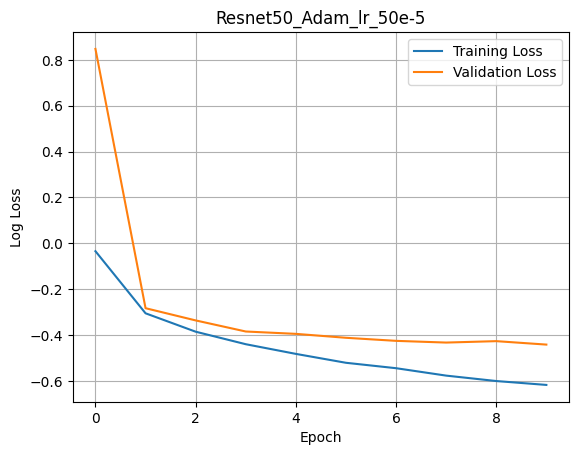

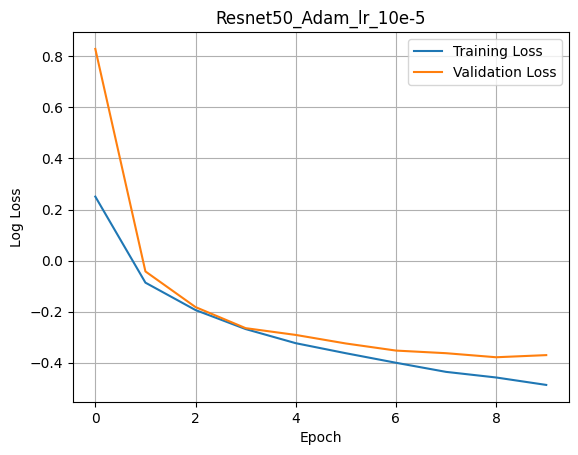

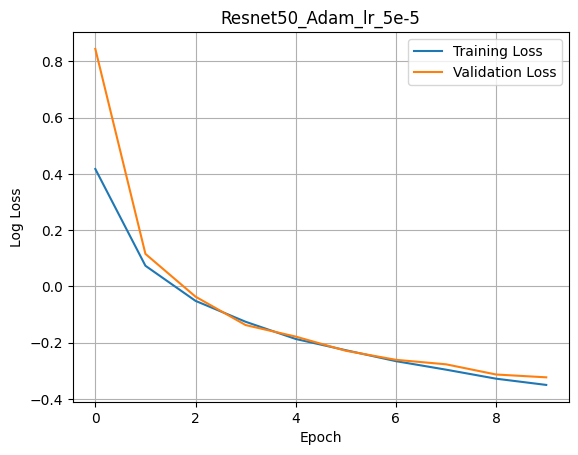

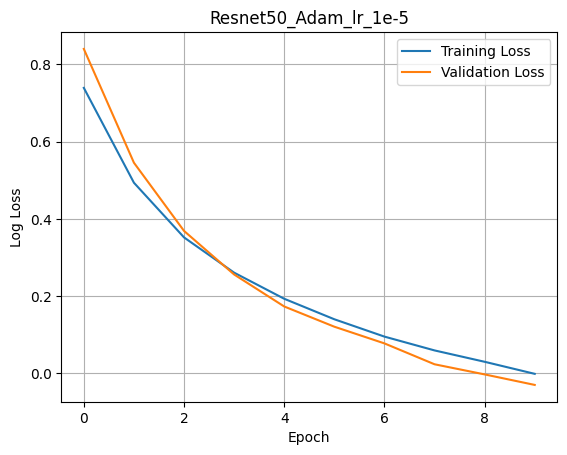

In [ ]:
performance_dict = {}
for lr in [5e-4, 1e-4, 5e-5, 1e-5]:
    model_res = torchvision.models.resnet50(weights="DEFAULT")
    fine_model = Resnet_TL(model_res)
    model_string = "Resnet50_Adam_lr_" + str(int(lr*1e5)) + "e-5"
    print(model_string)
    n_epochs = 10
    train_hist, val_hist = train_model(fine_model, trainloader, valloader, n_epochs=n_epochs, lr=lr)
    plot_losses(train_hist, val_hist, caption=model_string)
    acc, f1, conf = evaluate_model(fine_model, testloader)
    performance_dict[model_string] = [fine_model, train_hist, val_hist, acc, f1, conf]

In [ ]:
torch.save(performance_dict, 'RESNET.pth')

In [ ]:
performance_dict=torch.load('RESNET.pth')

/tmp/ipykernel_23/2686034848.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  performance_dict=torch.load('RESNET.pth')


In [ ]:
for key, item in performance_dict.items():
    print(f"{key}    Train_loss = {item[1][-1]:.3f}    Val_loss = {item[2][-1]:.3f}    Test_Acc = {item[3]:.3f}    Test_F1 = {item[4]:.3f}")

Resnet50_Adam_lr_50e-5    Train_loss = 0.539    Val_loss = 0.643    Test_Acc = 0.780    Test_F1 = 0.771
Resnet50_Adam_lr_10e-5    Train_loss = 0.614    Val_loss = 0.691    Test_Acc = 0.773    Test_F1 = 0.762
Resnet50_Adam_lr_5e-5    Train_loss = 0.705    Val_loss = 0.724    Test_Acc = 0.761    Test_F1 = 0.750
Resnet50_Adam_lr_1e-5    Train_loss = 0.999    Val_loss = 0.971    Test_Acc = 0.701    Test_F1 = 0.690


Based on the above results, we can see that the model trained with a learning rate of 0.0005 performs the best with the highest test accuracy and f1 score.

#### VGG19

In [ ]:
class VGG19_TL(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        # Use only the feature extractor from VGG19
        self.features = pretrained_model.features
        for param in self.features.parameters():
            param.requires_grad = False  # Freeze feature extractor layers

        # Replace classifier with custom head
        feature_size = pretrained_model.classifier[0].in_features  # Get the input size to the first FC layer
        self.batch_norm = nn.BatchNorm1d(feature_size)
        self.dropout = nn.Dropout(0.5)
        self.trainable = nn.Linear(feature_size, 10)

    def forward(self, x):
        # Pass through frozen feature extractor
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten for fully connected layer
        x = self.batch_norm(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.trainable(x)
        return x

In [ ]:
VGG_dict = {}

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 174MB/s]


VGG19_Adam_lr_50e-5
Epoch 1 / 10   Train_loss: 0.579   Val_loss: 2.353   Time: 5.031 mins
Epoch 2 / 10   Train_loss: 0.292   Val_loss: 0.419   Time: 5.053 mins
Epoch 3 / 10   Train_loss: 0.225   Val_loss: 0.431   Time: 5.061 mins
Epoch 4 / 10   Train_loss: 0.188   Val_loss: 0.413   Time: 5.056 mins
Epoch 5 / 10   Train_loss: 0.160   Val_loss: 0.401   Time: 5.050 mins
Epoch 6 / 10   Train_loss: 0.153   Val_loss: 0.411   Time: 5.056 mins
Epoch 7 / 10   Train_loss: 0.140   Val_loss: 0.384   Time: 5.056 mins
Epoch 8 / 10   Train_loss: 0.133   Val_loss: 0.380   Time: 5.060 mins
Epoch 9 / 10   Train_loss: 0.136   Val_loss: 0.393   Time: 5.059 mins
Epoch 10 / 10   Train_loss: 0.131   Val_loss: 0.372   Time: 5.056 mins
Finished Training


VGG19_Adam_lr_10e-5
Epoch 1 / 10   Train_loss: 0.775   Val_loss: 2.334   Time: 5.049 mins
Epoch 2 / 10   Train_loss: 0.412   Val_loss: 0.478   Time: 5.054 mins
Epoch 3 / 10   Train_loss: 0.329   Val_loss: 0.406   Time: 5.056 mins
Epoch 4 / 10   Train_loss: 0.

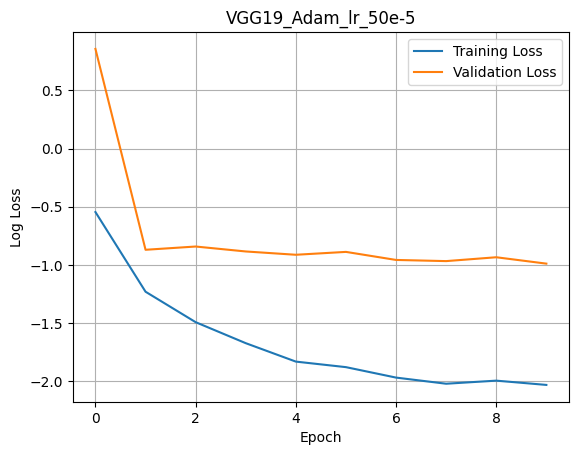

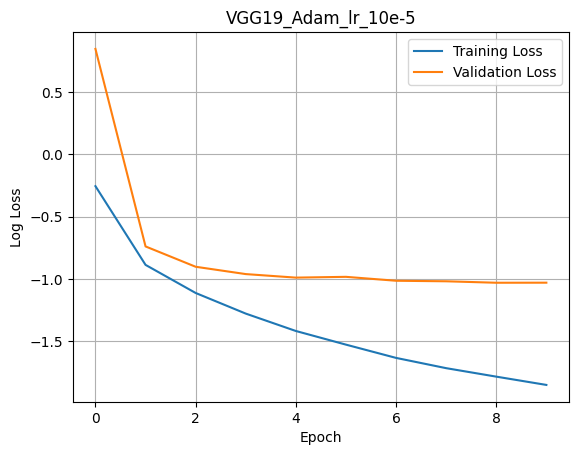

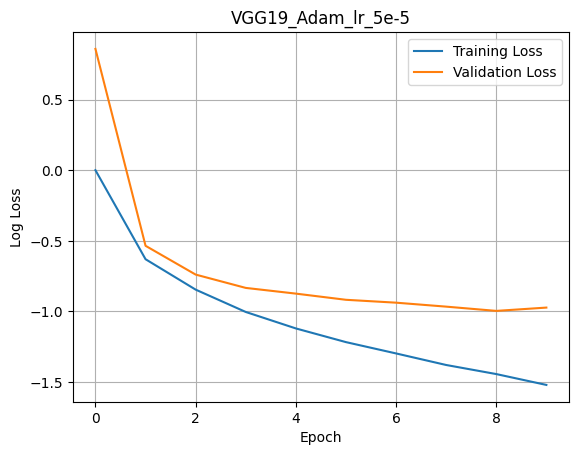

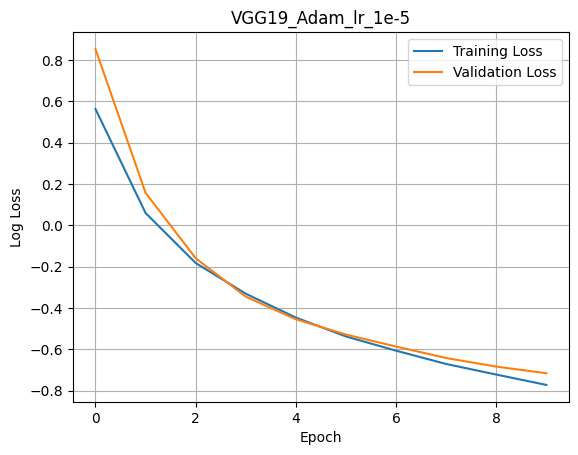

In [ ]:
for lr in [5e-4, 1e-4, 5e-5, 1e-5]:
    model_res = torchvision.models.vgg19(weights="DEFAULT")
    fine_model = VGG19_TL(model_res)
    model_string = "VGG19_Adam_lr_" + str(int(lr*1e5)) + "e-5"
    n_epochs = 10
    print(model_string)
    train_hist, val_hist = train_model(fine_model, trainloader, valloader, n_epochs=n_epochs, lr=lr)
    plot_losses(train_hist, val_hist, caption=model_string)
    acc, f1, conf = evaluate_model(fine_model, testloader)
    VGG_dict[model_string] = [fine_model, train_hist, val_hist, acc, f1, conf]
    print("\n")

In [ ]:
torch.save(VGG_dict, 'VGG19.pth')

In [ ]:
performance_dict=torch.load('VGG19.pth')

/tmp/ipykernel_23/3022931561.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  performance_dict=torch.load('VGG19.pth')


In [ ]:
for key, item in performance_dict.items():
    print(f"{key}    Train_loss = {item[1][-1]:.3f}    Val_loss = {item[2][-1]:.3f}    Test_Acc = {item[3]:.3f}    Test_F1 = {item[4]:.3f}")

VGG19_Adam_lr_50e-5    Train_loss = 0.131    Val_loss = 0.372    Test_Acc = 0.870    Test_F1 = 0.867
VGG19_Adam_lr_10e-5    Train_loss = 0.157    Val_loss = 0.357    Test_Acc = 0.870    Test_F1 = 0.867
VGG19_Adam_lr_5e-5    Train_loss = 0.219    Val_loss = 0.378    Test_Acc = 0.870    Test_F1 = 0.867
VGG19_Adam_lr_1e-5    Train_loss = 0.462    Val_loss = 0.489    Test_Acc = 0.844    Test_F1 = 0.841


Based on the above results, we can see that the model trained with a learning rate of 0.00005 performs the best with the highest test accuracy and f1 score.

#### Inception_v3

In [ ]:
transform = transforms.Compose([
    transforms.Resize(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

In [ ]:
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

In [ ]:
batch_size = 256
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
class Inception_TL(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.features = pretrained_model
        for param in self.features.parameters():
            param.requires_grad = False  # Freeze feature extractor layers
        self.batch_norm = nn.BatchNorm1d(1000)
        self.dropout = nn.Dropout(0.5)
        self.trainable = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.features(x)
        if isinstance(x, torchvision.models.InceptionOutputs):
            x = x.logits
        x = F.relu(self.batch_norm(x))
        # x = self.dropout(x)
        x = self.trainable(x)
        return x

In [ ]:
Inception_dict = {}

Inceptionv3_Adam_lr_50e-5
Epoch 1 / 10   Train_loss: 1.334   Val_loss: 2.554   Time: 3.761 mins
Epoch 2 / 10   Train_loss: 0.992   Val_loss: 1.015   Time: 3.817 mins
Epoch 3 / 10   Train_loss: 0.927   Val_loss: 0.907   Time: 3.813 mins
Epoch 4 / 10   Train_loss: 0.899   Val_loss: 0.858   Time: 3.822 mins
Epoch 5 / 10   Train_loss: 0.882   Val_loss: 0.851   Time: 3.814 mins
Epoch 6 / 10   Train_loss: 0.866   Val_loss: 0.817   Time: 3.815 mins
Epoch 7 / 10   Train_loss: 0.854   Val_loss: 0.820   Time: 3.817 mins
Epoch 8 / 10   Train_loss: 0.855   Val_loss: 0.803   Time: 3.809 mins
Epoch 9 / 10   Train_loss: 0.845   Val_loss: 0.817   Time: 3.813 mins
Epoch 10 / 10   Train_loss: 0.841   Val_loss: 0.802   Time: 3.815 mins
Finished Training


Inceptionv3_Adam_lr_10e-5
Epoch 1 / 10   Train_loss: 1.832   Val_loss: 2.408   Time: 3.814 mins
Epoch 2 / 10   Train_loss: 1.378   Val_loss: 1.498   Time: 3.823 mins
Epoch 3 / 10   Train_loss: 1.204   Val_loss: 1.234   Time: 3.821 mins
Epoch 4 / 10   Tr

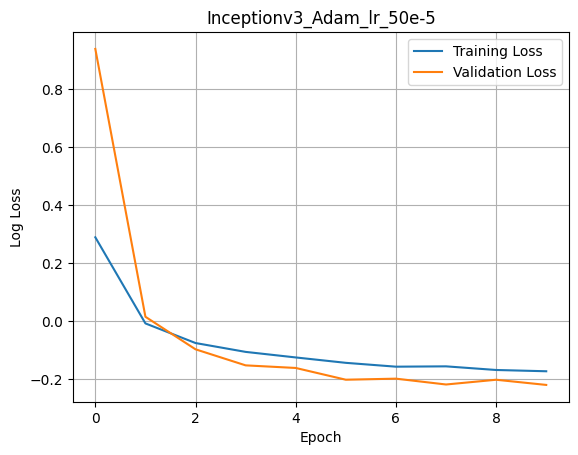

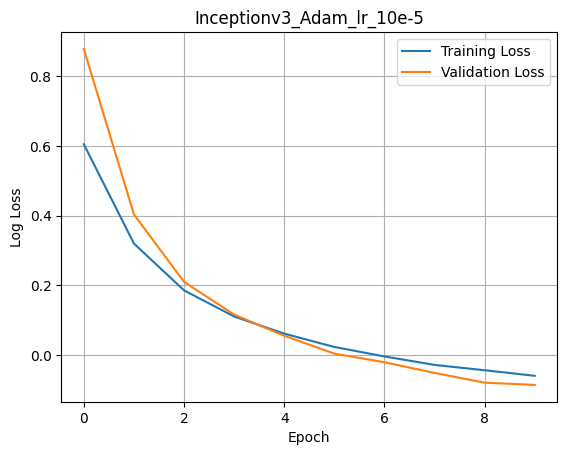

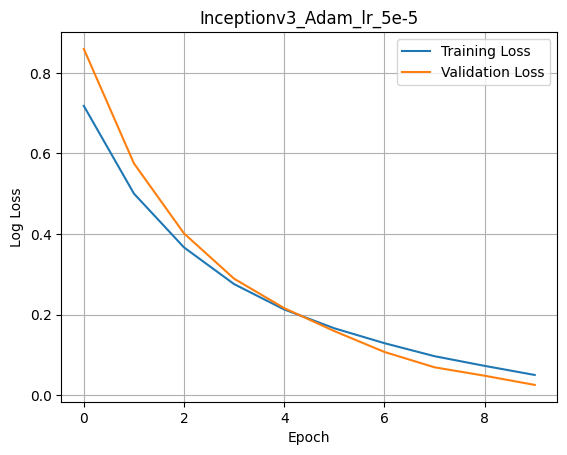

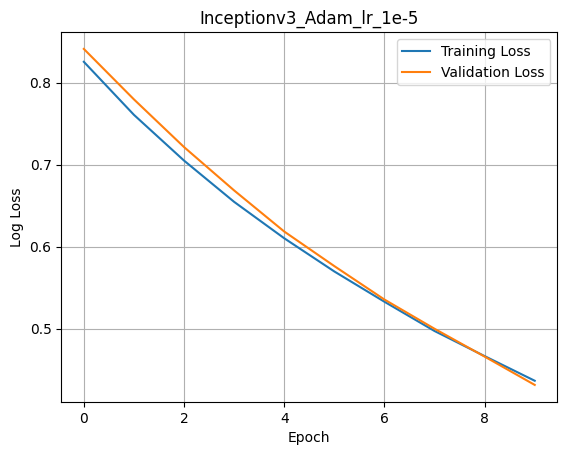

In [ ]:
for lr in [5e-4, 1e-4, 5e-5, 1e-5]:
    model_inc = torchvision.models.inception_v3(weights="DEFAULT")
    fine_model = Inception_TL(model_inc)
    model_string = "Inceptionv3_Adam_lr_" + str(int(lr*1e5)) + "e-5"
    n_epochs = 10
    print(model_string)
    train_hist, val_hist = train_model(fine_model, trainloader, valloader, n_epochs=n_epochs, lr=lr)
    plot_losses(train_hist, val_hist, caption=model_string)
    acc, f1, conf = evaluate_model(fine_model, testloader)
    Inception_dict[model_string] = [fine_model, train_hist, val_hist, acc, f1, conf]
    print("\n")

In [ ]:
torch.save(Inception_dict, 'Inception.pth')

In [ ]:
performance_dict=torch.load('Inception.pth')

/tmp/ipykernel_23/2828010761.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  performance_dict=torch.load('Inception.pth')


In [ ]:
for key, item in performance_dict.items():
    print(f"{key}    Train_loss = {item[1][-1]:.3f}    Val_loss = {item[2][-1]:.3f}    Test_Acc = {item[3]:.3f}    Test_F1 = {item[4]:.3f}")

Inceptionv3_Adam_lr_50e-5    Train_loss = 0.841    Val_loss = 0.802    Test_Acc = 0.732    Test_F1 = 0.723
Inceptionv3_Adam_lr_10e-5    Train_loss = 0.942    Val_loss = 0.918    Test_Acc = 0.708    Test_F1 = 0.697
Inceptionv3_Adam_lr_5e-5    Train_loss = 1.051    Val_loss = 1.025    Test_Acc = 0.686    Test_F1 = 0.676
Inceptionv3_Adam_lr_1e-5    Train_loss = 1.547    Val_loss = 1.539    Test_Acc = 0.575    Test_F1 = 0.564


Based on the above results, we can see that the model trained with a learning rate of 0.0005 performs the best with the highest test accuracy and f1 score.

## Vision Transformer

### Building our own ViTs

In [ ]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

batch_size = 64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

#### ViT Architecture

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.projection(x)    # Shape: [batch_size, embed_dim, H/patch_size, W/patch_size]
        x = x.flatten(2)          # Shape: [batch_size, embed_dim, n_patches]
        x = x.transpose(1, 2)     # Shape: [batch_size, n_patches, embed_dim]
        return x


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, x):
        x = x.transpose(0, 1)                       # Transpose for Attention: [n_patches, batch_size, embed_dim]
        attn_output, _ = self.attention(x, x, x)
        return attn_output.transpose(0, 1)          # Transpose back: [batch_size, n_patches, embed_dim]


class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, expansion=4, dropout=0.5):
        super().__init__()
        self.attention = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, expansion * embed_dim),
            nn.GELU(),
            nn.Linear(expansion * embed_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-Attention and Add & Norm
        x = x + self.dropout(self.attention(self.norm1(x)))
        # Feed Forward Network and Add & Norm
        x = x + self.dropout(self.ffn(self.norm2(x)))
        return x


class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=16, in_channels=3, embed_dim=768, num_heads=12, num_layers=12, num_classes=10):
        super().__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.position_embedding = nn.Parameter(torch.randn(1, 1 + self.patch_embedding.n_patches, embed_dim))
        self.transformer = nn.Sequential(
            *[TransformerEncoderLayer(embed_dim, num_heads) for _ in range(num_layers)]
        )

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        # Patch + Position Embedding
        x = self.patch_embedding(x)
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embedding

        # Transformer Encoder
        x = self.transformer(x)

        # Classification Head
        cls_output = x[:, 0]  # Take the class token output
        return self.mlp_head(cls_output)

In [ ]:
model_vit = VisionTransformer(img_size=32, patch_size=4, num_classes=10)
total_params(model_vit)

In [ ]:
performance_dict = {}

ViT_Patch_4_Embed_48_NLayers_4
Epoch 1 / 20   Train_loss: 1.920   Val_loss: 2.444   Time: 0.225 mins
Epoch 2 / 20   Train_loss: 1.616   Val_loss: 1.656   Time: 0.213 mins
Epoch 3 / 20   Train_loss: 1.489   Val_loss: 1.485   Time: 0.212 mins
Epoch 4 / 20   Train_loss: 1.419   Val_loss: 1.413   Time: 0.208 mins
Epoch 5 / 20   Train_loss: 1.375   Val_loss: 1.360   Time: 0.209 mins
Epoch 6 / 20   Train_loss: 1.340   Val_loss: 1.318   Time: 0.212 mins
Epoch 7 / 20   Train_loss: 1.304   Val_loss: 1.298   Time: 0.207 mins
Epoch 8 / 20   Train_loss: 1.285   Val_loss: 1.296   Time: 0.216 mins
Epoch 9 / 20   Train_loss: 1.256   Val_loss: 1.253   Time: 0.211 mins
Epoch 10 / 20   Train_loss: 1.240   Val_loss: 1.230   Time: 0.212 mins
Epoch 11 / 20   Train_loss: 1.223   Val_loss: 1.241   Time: 0.207 mins
Epoch 12 / 20   Train_loss: 1.205   Val_loss: 1.195   Time: 0.207 mins
Epoch 13 / 20   Train_loss: 1.198   Val_loss: 1.184   Time: 0.216 mins
Epoch 14 / 20   Train_loss: 1.182   Val_loss: 1.171   T

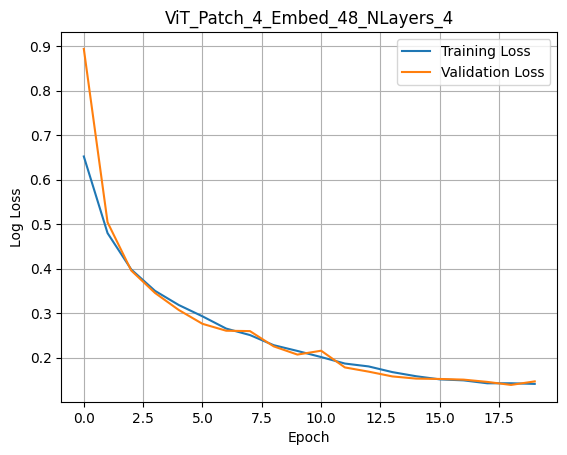

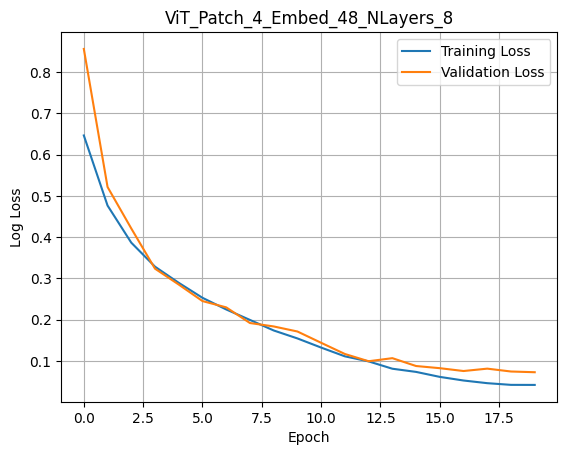

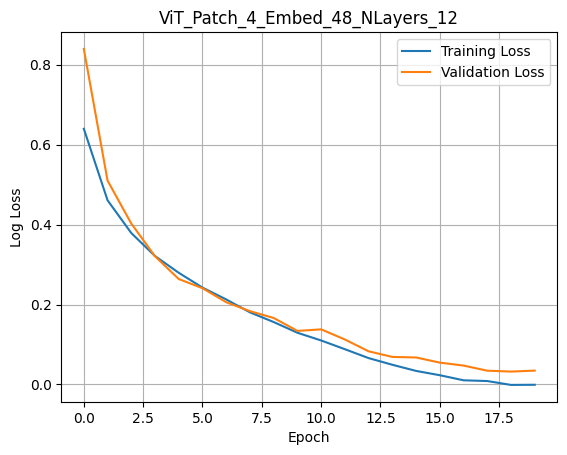

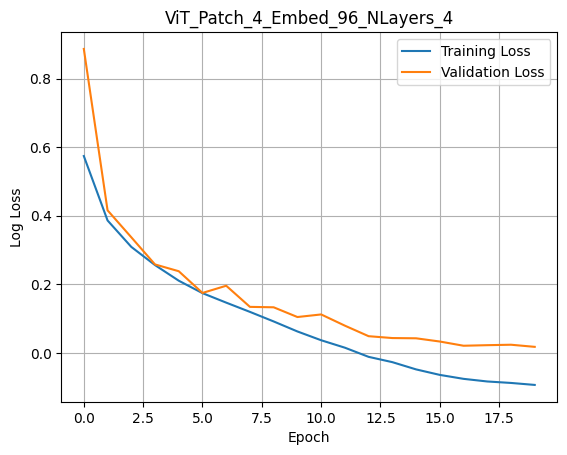

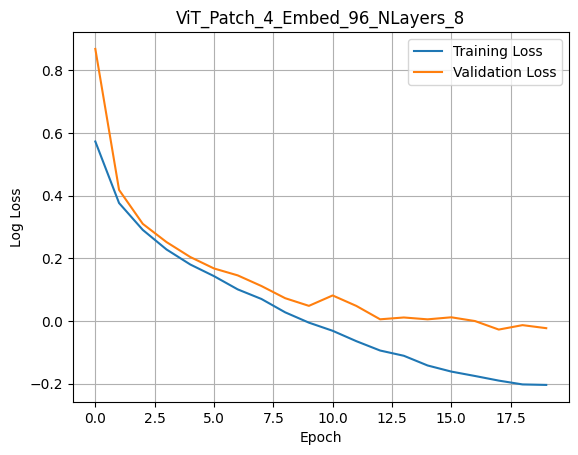

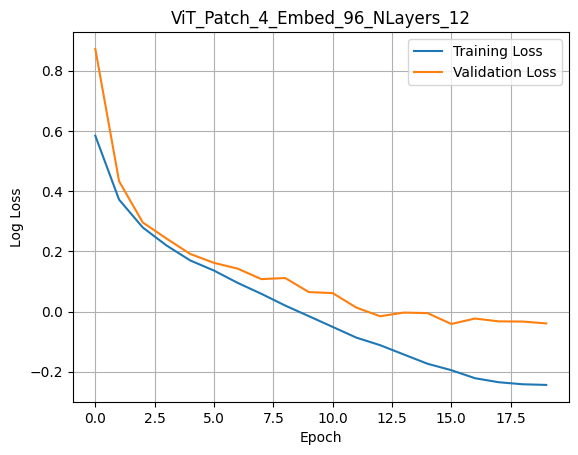

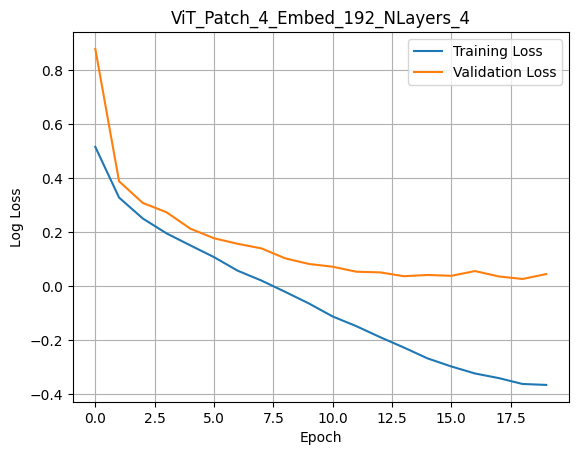

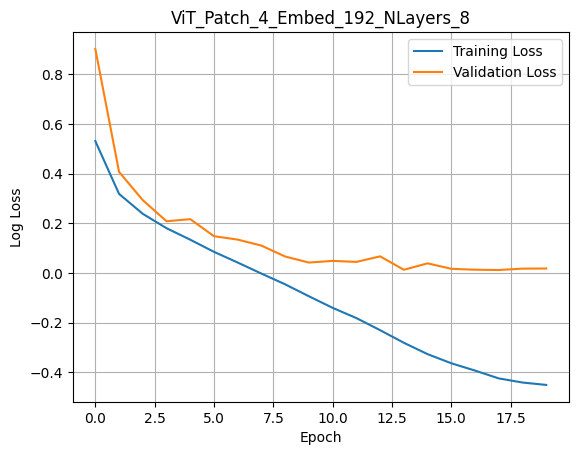

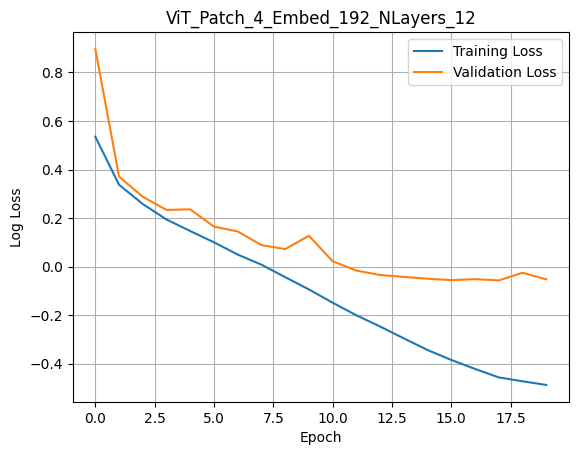

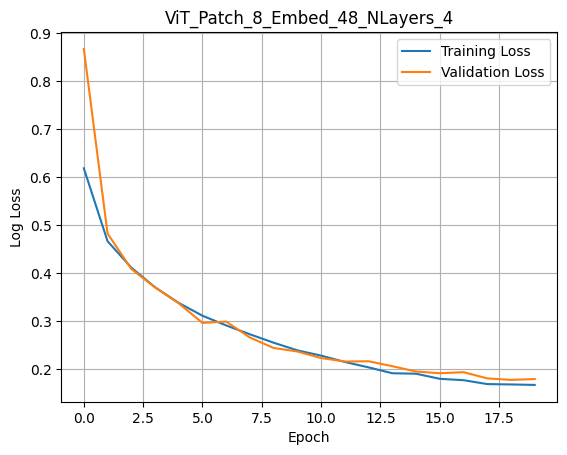

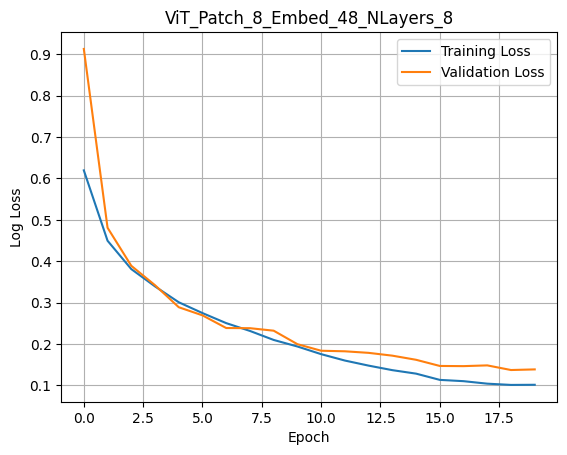

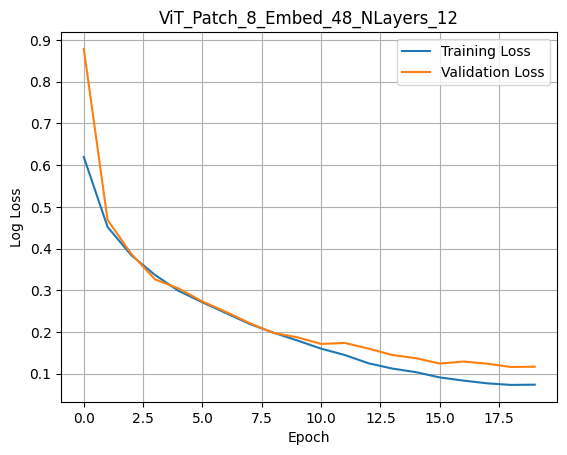

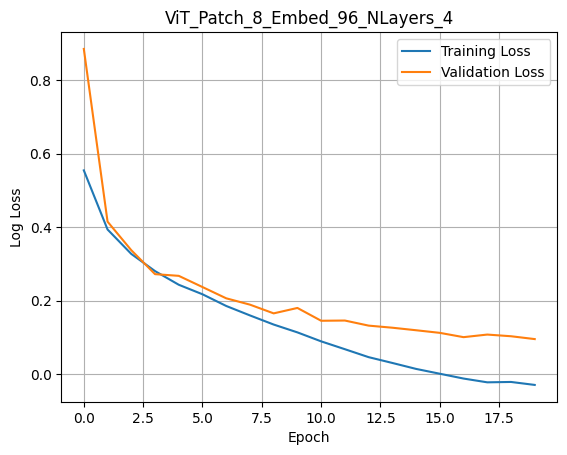

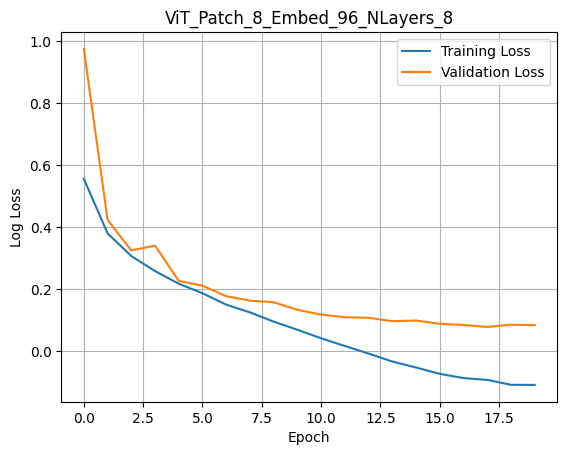

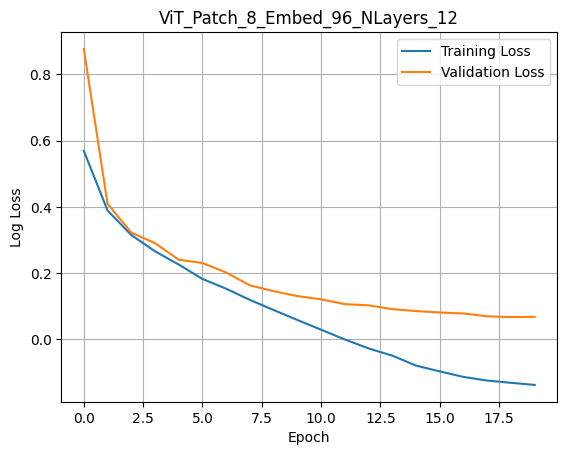

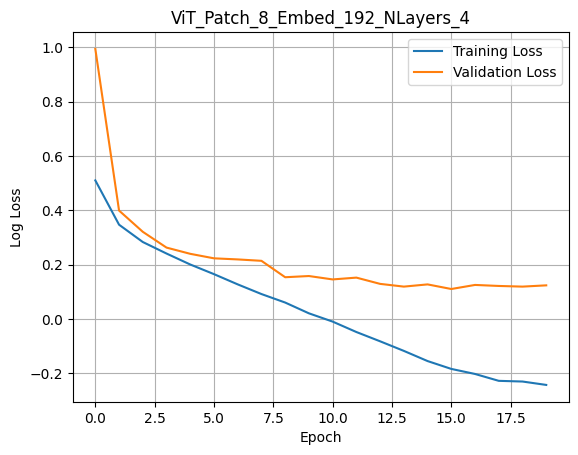

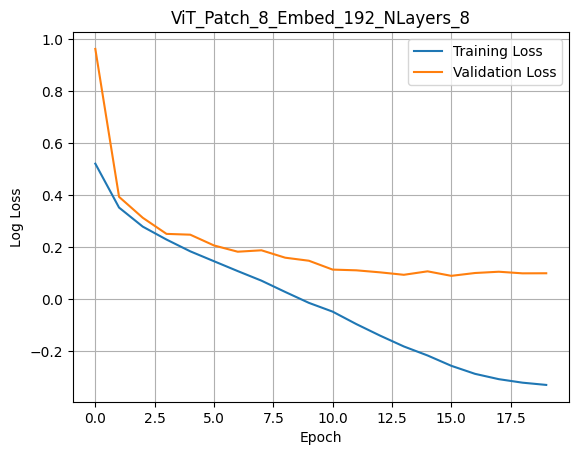

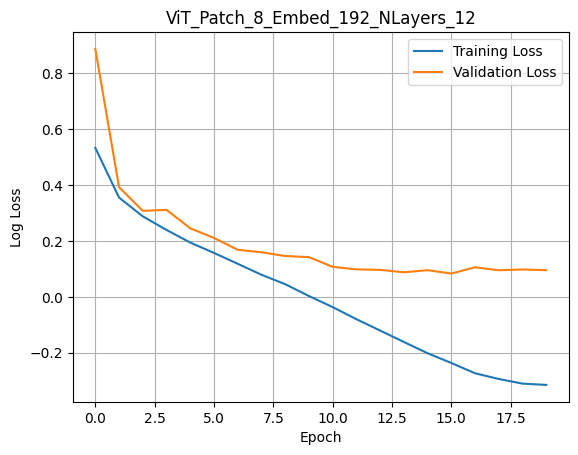

In [ ]:
n_epochs = 20
lr = 5e-4

for patch_size in [4, 8]:
    for embed_dim in [48, 96, 192]:
        for num_layers in [4, 8, 12]:
            model_string = f"ViT_Patch_{patch_size}_Embed_{embed_dim}_NLayers_{num_layers}"
            print(model_string)
            model_vit = VisionTransformer(img_size=32, num_classes=10, patch_size=patch_size, embed_dim = embed_dim, num_layers=num_layers)
            train_hist, val_hist = train_model(model_vit, trainloader, valloader, n_epochs=n_epochs, lr=lr)
            plot_losses(train_hist, val_hist, caption=model_string)
            acc, f1, conf = evaluate_model(model_vit, testloader)
            performance_dict[model_string] = [model_vit, total_params(model_vit), train_hist, val_hist, acc, f1, conf]
            print("\n")

In [ ]:
torch.save(performance_dict, 'ViT_perf.pth')

In [ ]:
performance_dict=torch.load('ViT_perf.pth')

/tmp/ipykernel_24/4217723413.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  performance_dict=torch.load('ViT_perf.pth')


In [ ]:
for key, item in performance_dict.items():
    print(f"{key}    Params = {item[1]}    Train_loss = {item[2][-1]:.3f}    Val_loss = {item[3][-1]:.3f}    Test_Acc = {item[4]:.3f}    Test_F1 = {item[5]:.3f}")

ViT_Patch_4_Embed_48_NLayers_4    Params = 119194    Train_loss = 1.151    Val_loss = 1.158    Test_Acc = 0.586    Test_F1 = 0.561
ViT_Patch_4_Embed_48_NLayers_8    Params = 232282    Train_loss = 1.042    Val_loss = 1.075    Test_Acc = 0.617    Test_F1 = 0.591
ViT_Patch_4_Embed_48_NLayers_12    Params = 345370    Train_loss = 0.999    Val_loss = 1.035    Test_Acc = 0.631    Test_F1 = 0.607
ViT_Patch_4_Embed_96_NLayers_4    Params = 459562    Train_loss = 0.911    Val_loss = 1.018    Test_Acc = 0.643    Test_F1 = 0.618
ViT_Patch_4_Embed_96_NLayers_8    Params = 906922    Train_loss = 0.815    Val_loss = 0.977    Test_Acc = 0.662    Test_F1 = 0.640
ViT_Patch_4_Embed_96_NLayers_12    Params = 1354282    Train_loss = 0.784    Val_loss = 0.961    Test_Acc = 0.674    Test_F1 = 0.651
ViT_Patch_4_Embed_192_NLayers_4    Params = 1803850    Train_loss = 0.693    Val_loss = 1.045    Test_Acc = 0.679    Test_F1 = 0.657
ViT_Patch_4_Embed_192_NLayers_8    Params = 3583306    Train_loss = 0.637    V

### Transfer Learning from pre-trained ViT

In [ ]:
#Training and testing data
#CIFAR-10
batch_size = 32

transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]) #Resizing according to size required by transformer
train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

#Splitting
train_size = int(0.8*len(train))
val_size = len(train) - train_size
trainset,valset = random_split(train,[train_size,val_size])


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset,batch_size=batch_size,shuffle=True,num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False,num_workers=2)


100%|██████████| 170M/170M [00:04<00:00, 41.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
#Importing a pre-trained vit_b_16 architecture from the original paper. This architecture is used because it has the least number of parameters available.
vit = models.vit_b_16(pretrained=True,progress=True)
for param in vit.parameters():
  param.requires_grad = False

num_classes = 10
in_features = vit.heads[-1].in_features

vit.heads[-1] = torch.nn.Linear(in_features,num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
total_params = lambda model: sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params(vit))

7690


In [ ]:
#Training function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(),lr=0.001)

def trainvit(model,loader):
  model.train()
  running_loss = 0
  for images,labels in loader:
    images,labels = images.to(device) , labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  return running_loss/len(loader)

In [ ]:
#Validation function
def validate(model,loader):
  model.eval()
  running_loss = 0
  correct = 0
  with torch.no_grad():
    for images,labels in loader:
      images,labels = images.to(device),labels.to(device)
      outputs = model(images)
      loss = criterion(outputs,labels)
      running_loss += loss.item()

    return running_loss/len(loader)

In [ ]:
#Testing function
def test(model,loader):
  model.eval()
  correct = 0
  with torch.no_grad():
    for images,labels in loader:
      images,labels = images.to(device),labels.to(device)
      outputs = model(images)
      _,predicted = torch.max(outputs,1)
      correct += (predicted == labels).sum().item()
  accuracy = correct / len(loader.dataset)
  return accuracy

In [ ]:
#Training and testing the model -> vit

epochs = 5
for epoch in range(epochs):
  train_loss = trainvit(vit,trainloader)
  val_loss = validate(vit,valloader)
  print(f'Epoch:{epoch+1}, Training loss:{train_loss}, Validation loss:{val_loss}')

In [ ]:
#Testing the model

accuracy = test(vit,testloader)
print(accuracy)

In [ ]:
torch.save(vit.state_dict(),"best_ViT.pth")

## Adversarial Attack

We attack our best CNN and ViT with the Fast Gradient Sign Method (FGSM) adversarial attack

In [ ]:
def fgsm_attack(data, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_data = data + epsilon * sign_data_grad
    perturbed_data = torch.clamp(perturbed_data, 0, 1)    # To maintain [0,1] range
    return perturbed_data

def evaluate_under_FGSM(model, dataloader, epsilon=0.1):
    model.eval()
    total, correct = 0, 0
    f1_list = []
    for inputs, labels in dataloader:
        # Move data and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        inputs.requires_grad = True
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        # Collect the del (L) / del (image)
        data_grad = inputs.grad.data

        # Generate pertubed data
        perturbed_data = fgsm_attack(inputs, epsilon, data_grad)
        # adv_examples.append((perturbed_data, labels))

        # Predicting with purtubed data
        with torch.no_grad():
            new_outputs = model(perturbed_data)
            _, predicted = torch.max(new_outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            f1_list.append(f1_score(labels.cpu(), predicted.cpu(), average="macro"))

        inputs.requires_grad = False
        inputs.grad = None

    acc = correct / total
    f1 = np.mean(np.array(f1_list))

    return acc, f1

### Attacking our best CNN - VGG_19_Adam_lr_5e-5

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
saved_vgg = torch.load("VGG19.pth")
best_vgg = saved_vgg["VGG19_Adam_lr_5e-5"][0]
for param in best_vgg.parameters():
    param.requires_grad = False

In [ ]:
print("The performance of the CNN when subjected to different levels of FGSM are:")
for eps in [0.05, 0.1, 0.3]:
    acc, f1 = evaluate_under_FGSM(best_vgg, testloader, epsilon=eps)
    print(f"Eps = {eps:.2f}    Accuracy (%) = {acc*100:.2f}    F1 Score = {f1:.3f}")

### Attacking our best ViT

In [ ]:
model = torchvision.models.vit_b_16()
model.heads[-1] = torch.nn.Linear(model.heads[-1].in_features, 10)
model.load_state_dict(torch.load("best_ViT.pth"))
model.to(device)

for param in model.parameters():
    param.requires_grad = False

In [ ]:
print("The performance of the ViT when subjected to different levels of FGSM are:")
for eps in [0.05, 0.1, 0.3]:
    acc, f1 = evaluate_under_FGSM(model, testloader, epsilon=eps)
    print(f"Eps = {eps:.2f}    Accuracy (%) = {acc*100:.2f}    F1 Score = {f1:.3f}")